In [1]:
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.scipy as jsp

# Partially initialize functions
from functools import partial

# TFP
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# GP Kernels
from tinygp import kernels

# sklearn
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Optimization
import optax

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['scatter.edgecolors'] = "k"

# Progress bar
from tqdm import tqdm

# Jitter
JITTER = 1e-6

# Enable JAX 64bit
jax.config.update("jax_enable_x64", True)

2022-11-17 00:15:54.400034: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 00:15:55.059351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:/opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-11-17 00:15:55.059458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/l

In [2]:
import distrax

In [3]:
XLA_PYTHON_CLIENT_MEM_FRACTION = 0.5
XLA_PYTHON_CLIENT_PREALLOCATE = False


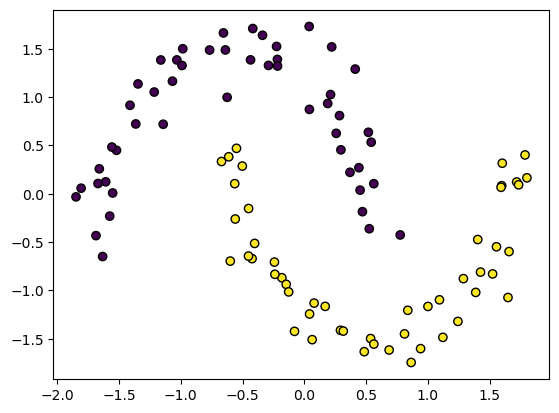

In [4]:
n_samples = 100
noise = 0.1
random_state = 0
shuffle = True

X, y = make_moons(
    n_samples=n_samples, random_state=random_state, noise=noise, shuffle=shuffle
)
X = StandardScaler().fit_transform(X)  # Yes, this is useful for GPs

X, y = map(jnp.array, (X, y))

plt.scatter(X[:, 0], X[:, 1], c=y)


In [5]:
y.shape

(100,)

In [6]:
import warnings
import seaborn as sns
import tensorflow_probability as tfp  # tensorflow probability
import jax  # autograd + XLA
import jax.numpy as jnp  # ai-accelerator agnostic numpy implementations
import pandas as pd  # lets us handle data as dataframes
import matplotlib.pyplot as plt  # sets up plotting under plt
import matplotlib.cm as cm  # allows us easy access to colormaps
import matplotlib as mpl  # this actually imports matplotlib
import scipy as sp  # imports stats functions, amongst other things
import numpy as np  # imports a fast numerical programming library
from operator import index
from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit
import optax as ox
key = jr.PRNGKey(123)

warnings.filterwarnings("ignore")

%matplotlib inline


In [7]:
lengthscale = 1.0
variance = 1.0

kernel_fn = variance * kernels.ExpSquared(scale=lengthscale)

kernel_fn(X, X).shape


(100, 100)

In [8]:
key = jax.random.PRNGKey(0)
n_inducing = 10
n_dim = X.shape[1]

X_inducing = jax.random.normal(key, shape=(n_inducing, n_dim))
X_inducing.shape


(10, 2)

In [9]:
CUDA_VISIBLE_DEVICES=1

In [10]:
gp_mean = 0.43  # a scalar parameter to train

prior_mean = gp_mean * jnp.zeros(n_inducing)
prior_cov = kernel_fn(X_inducing, X_inducing)


In [11]:
prior_distribution = distrax.MultivariateNormalFullCovariance(prior_mean, prior_cov)

In [12]:
variational_mean = jax.random.uniform(key, shape=(n_inducing,)) # a vector parameter to train

In [13]:
random_vector = jax.random.normal(key, shape=(3,))
corr_chol = tfb.CorrelationCholesky()(random_vector)
correlation = corr_chol@corr_chol.T
correlation


DeviceArray([[ 1.        ,  0.54464529, -0.7835968 ],
             [ 0.54464529,  1.        , -0.33059078],
             [-0.7835968 , -0.33059078,  1.        ]], dtype=float64)

In [14]:
random_vector = jax.random.normal(
    key, shape=(n_inducing * (n_inducing - 1) // 2,)
)  # a trainable parameter
log_sigma = jax.random.normal(key, shape=(
    n_inducing, 1))  # a trainable parameter


sigma = jnp.exp(log_sigma)
corr_chol = tfb.CorrelationCholesky()(random_vector)
variational_cov = sigma * sigma.T * (corr_chol @ corr_chol.T)
print(variational_cov.shape)


(10, 10)


In [15]:

variational_distribution = distrax.MultivariateNormalFullCovariance(variational_mean, variational_cov
                                                                )


In [16]:
variational_distribution.kl_divergence(prior_distribution)


DeviceArray(416.89357355, dtype=float64)

In [17]:
f = jax.random.normal(key, shape=y.shape)
likelihood_distribution = distrax.Bernoulli(logits=f)

log_likelihood = likelihood_distribution.log_prob(y).sum()
log_likelihood

DeviceArray(-72.04665624, dtype=float64)

In [18]:
def q_f(x_i):
    x_i = x_i.reshape(1, -1)  # ensure correct shape
    K_im = kernel_fn(x_i, X_inducing)
    K_mm = kernel_fn(X_inducing, X_inducing)
    chol_mm = jnp.linalg.cholesky(K_mm + jnp.eye(K_mm.shape[0])*JITTER)
    A = jsp.linalg.cho_solve((chol_mm, True), K_im.T).T

    mu_i = A@variational_mean
    sigma_sqr_i = kernel_fn(x_i, x_i) + A@(variational_cov - prior_cov)@A.T

    return distrax.Normal(loc=mu_i, scale=sigma_sqr_i**0.5)


In [19]:
def log_likelihood(x_i, y_i, seed):
    sample = q_f(x_i).sample(seed=seed)
    log_likelihood = distrax.Bernoulli(logits=sample).log_prob(y_i)
    return log_likelihood.squeeze()

In [20]:
log_likelihood(X[0], y[0], seed=key)


DeviceArray(-0.17831203, dtype=float64)

In [21]:
batch_size = 10

seeds = jax.random.split(key, num=batch_size)

ll = len(y)/batch_size * \
    jax.vmap(log_likelihood)(X[:batch_size], y[:batch_size], seeds).sum()
ll


DeviceArray(-215.46520331, dtype=float64)

In [22]:
class SVGP:
    def __init__(self, X_inducing, data_size):
        self.X_inducing = X_inducing
        self.n_inducing = len(X_inducing)
        self.data_size = data_size

    def init_params(self, seed):
        variational_corr_chol_param = tfb.CorrelationCholesky().inverse(
            jnp.eye(self.n_inducing))

        dummy_params = {"log_variance": jnp.zeros(()),
                        "log_scale": jnp.zeros(()),
                        "mean": jnp.zeros(()),
                        "X_inducing": self.X_inducing,
                        "variational_mean": jnp.zeros(self.n_inducing),
                        "variational_corr_chol_param": variational_corr_chol_param,
                        "log_variational_sigma": jnp.zeros((self.n_inducing, 1)),
                        }

        flat_params, unravel_fn = ravel_pytree(dummy_params)
        random_params = jax.random.normal(key, shape=(len(flat_params), ))
        params = unravel_fn(random_params)
        return params

    @staticmethod
    def get_constrained_params(params):
        return {"mean": params["mean"],
                "variance": jnp.exp(params['log_variance']),
                "scale": jnp.exp(params['log_scale']),
                "X_inducing": params["X_inducing"],
                "variational_mean": params["variational_mean"],
                "variational_corr_chol_param": params["variational_corr_chol_param"],
                "variational_sigma": jnp.exp(params["log_variational_sigma"])}

    @staticmethod
    def get_q_f(params, x_i, prior_distribution, variational_distribution):
        x_i = x_i.reshape(1, -1)  # ensure correct shape

        kernel_fn = params['variance'] * \
            kernels.ExpSquared(scale=params["scale"])
        K_im = kernel_fn(x_i, params["X_inducing"])
        K_mm = prior_distribution.covariance()
        chol_mm = jnp.linalg.cholesky(K_mm)
        A = jsp.linalg.cho_solve((chol_mm, True), K_im.T).T

        mu_i = A@params["variational_mean"]
        sigma_sqr_i = kernel_fn(
            x_i, x_i) + A@(variational_distribution.covariance() - K_mm)@A.T

        return tfd.Normal(loc=mu_i, scale=sigma_sqr_i**0.5)

    def get_distributions(self, params):
        kernel_fn = params['variance'] * \
            kernels.ExpSquared(scale=params["scale"])
        prior_mean = params["mean"]
        prior_cov = kernel_fn(
            params["X_inducing"], params["X_inducing"]) + jnp.eye(self.n_inducing)*JITTER
        prior_distribution = tfd.MultivariateNormalFullCovariance(
            prior_mean, prior_cov)

        corr_chol = tfb.CorrelationCholesky()(
            params["variational_corr_chol_param"])
        sigma = jnp.diag(params["variational_sigma"])
        variational_cov = sigma*sigma.T * \
            (corr_chol@corr_chol.T) + jnp.eye(self.n_inducing)*JITTER
        variational_distribution = tfd.MultivariateNormalFullCovariance(
            params["variational_mean"], variational_cov)

        return prior_distribution, variational_distribution

    def loss_fn(self, params, X_batch, y_batch, seed):
        params = self.get_constrained_params(params)

        # Get distributions
        prior_distribution, variational_distribution = self.get_distributions(
            params)

        # Compute kl
        kl = variational_distribution.kl_divergence(prior_distribution)

        # Compute log likelihood
        def log_likelihood_fn(x_i, y_i, seed):
            q_f = self.get_q_f(params, x_i, prior_distribution,
                               variational_distribution)
            sample = q_f.sample(seed=seed)
            log_likelihood = tfd.Bernoulli(logits=sample).log_prob(y_i)
            return log_likelihood.squeeze()

        seeds = jax.random.split(seed, num=len(y_batch))
        log_likelihood = jax.vmap(log_likelihood_fn)(
            X_batch, y_batch, seeds).sum() * self.data_size/len(y_batch)

        return kl - log_likelihood

    def fit_fn(self, X, y, init_params, optimizer, n_iters, batch_size, seed):
        state = optimizer.init(init_params)
        value_and_grad_fn = jax.value_and_grad(self.loss_fn)

        def one_step(params_and_state, seed):
            params, state = params_and_state
            idx = jax.random.choice(
                seed, self.data_size, (batch_size,), replace=False)
            X_batch, y_batch = X[idx], y[idx]

            seed2 = jax.random.split(seed, 1)[0]
            loss, grads = value_and_grad_fn(params, X_batch, y_batch, seed2)
            updates, state = optimizer.update(grads, state)
            params = optax.apply_updates(params, updates)
            return (params, state), (loss, params)

        seeds = jax.random.split(seed, num=n_iters)
        (best_params, _), (loss_history, params_history) = jax.lax.scan(
            one_step, (init_params, state), xs=seeds)
        return best_params, loss_history, params_history

    def predict_fn(self, params, X_new):
        constrained_params = self.get_constrained_params(params)
        prior_distribution, variational_distribution = self.get_distributions(
            constrained_params)

        def _predict_fn(x_i):
            # Get posterior
            q_f = self.get_q_f(constrained_params, x_i,
                               prior_distribution, variational_distribution)
            return q_f.mean().squeeze(), q_f.variance().squeeze()

        mean, var = jax.vmap(_predict_fn)(X_new)
        return mean.squeeze(), var.squeeze()


In [23]:
n_inducing = 10
n_epochs = 50
batch_size = 10
data_size = len(y)
n_iters = n_epochs*(data_size/batch_size)
n_iters


500.0

In [24]:
key = jax.random.PRNGKey(0)
key2, subkey = jax.random.split(key)
optimizer = optax.adam(learning_rate=0.01)

X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
model = SVGP(X_inducing, data_size)

init_params = model.init_params(key2)


In [25]:
subkey

DeviceArray([2718843009, 1272950319], dtype=uint32)

Text(0.5, 1.0, 'Loss')

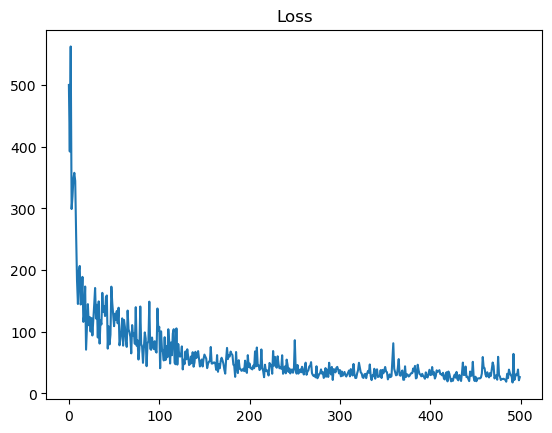

In [26]:
key = jax.random.PRNGKey(0)
key2, subkey = jax.random.split(key)
optimizer = optax.adam(learning_rate=0.01)

X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
model = SVGP(X_inducing, data_size)

init_params = model.init_params(key2)

model.loss_fn(init_params, X, y, key)
best_params, loss_history, params_history = model.fit_fn(
    X, y, init_params, optimizer, n_iters, batch_size, subkey)

plt.figure()
plt.plot(loss_history)
plt.title("Loss")


In [27]:
x = jnp.linspace(-3.5, 3.5, 100)
seed = jax.random.PRNGKey(123)

X1, X2 = jnp.meshgrid(x, x)


def f(x1, x2): return model.predict_fn(
    best_params, jnp.array([x1, x2]).reshape(1, -1))


pred_mean, pred_var = jax.vmap(jax.vmap(f))(X1, X2)
logits = tfd.Normal(pred_mean, pred_var **
                    0.5).sample(seed=seed, sample_shape=(10000,))
proba = jax.nn.sigmoid(logits)

proba_mean = proba.mean(axis=0)
proba_std2 = proba.std(axis=0)*2


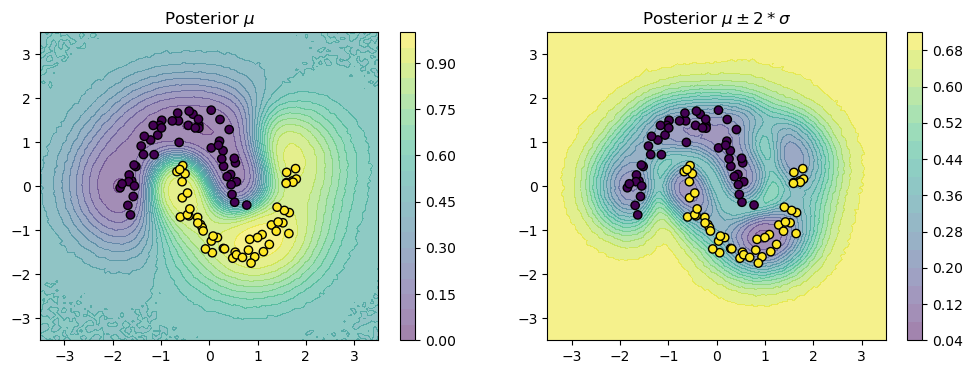

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
cplot1 = ax[0].contourf(X1, X2, proba_mean.squeeze(), alpha=0.5, levels=20)
plt.colorbar(cplot1, ax=ax[0])

cplot2 = ax[1].contourf(X1, X2, proba_std2.squeeze(), alpha=0.5, levels=20)
plt.colorbar(cplot2, ax=ax[1])

ax[0].scatter(X[:, 0], X[:, 1], c=y);
ax[1].scatter(X[:, 0], X[:, 1], c=y);

ax[0].set_title("Posterior $\mu$");
ax[1].set_title("Posterior $\mu \pm 2*\sigma$");


In [29]:
def mean_standardized_log_loss(
    y_true, y_pred, y_std, *, sample_weight=None, multioutput="uniform_average", squared=True
):
    """Mean standardized log loss.
    Read more in the :ref:`User Guide <mean_standardized_log_loss>`.
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    y_std : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated standard deviation in predictions.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like of shape \
            (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.

    Returns
    -------
    loss : float or ndarray of floats
        A non-negative floating point value (the best value is 0.0), or an
        array of floating point values, one for each individual target.
    Examples
    --------
    >>> from sklearn.metrics import mean_standardized_log_loss
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> y_std = [0.1, 0, 0.05, 0.3]
    >>> mean_standardized_log_loss(y_true, y_pred, y_std)
    6.356
    >>> y_true = [[0.5, 1],[-1, 1],[7, -6]]
    >>> y_pred = [[0, 2],[-1, 2],[8, -5]]
    >>> y_std = [[0.01, 0.02],[0.01,0.04],[0.03,0.04]]
    >>> mean_standardized_log_loss(y_true, y_pred, y_std)
    5.511
    >>> mean_squared_error(y_true, y_pred, multioutput='raw_values')
    array([5.00107605, 6.02159874])
    >>> mean_squared_error(y_true, y_pred, multioutput=[0.3, 0.7])
    2.858
    """
    # y_type, y_true, y_pred, multioutput = _check_reg_targets(
    #   y_true, y_pred, multioutput
    # )
    # check_consistent_length(y_true, y_pred, sample_weight)
    
    ###########
    # Checks like the above ones to be implemented.
    ###########
    
    first_term = 0.5 * np.log(2 * np.pi * y_std**2)
    second_term = ((y_true - y_pred)**2)/(2 * y_std**2)
    
    output_errors = np.average(first_term + second_term, axis=0, weights=sample_weight)

    if isinstance(multioutput, str):
        if multioutput == "raw_values":
            return output_errors
        elif multioutput == "uniform_average":
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

In [30]:
mean_standardized_log_loss(y, proba_mean, proba_std2)

1.396378323921159

Text(0.5, 1.0, 'Posterior $\\mu \\pm 2*\\sigma$')

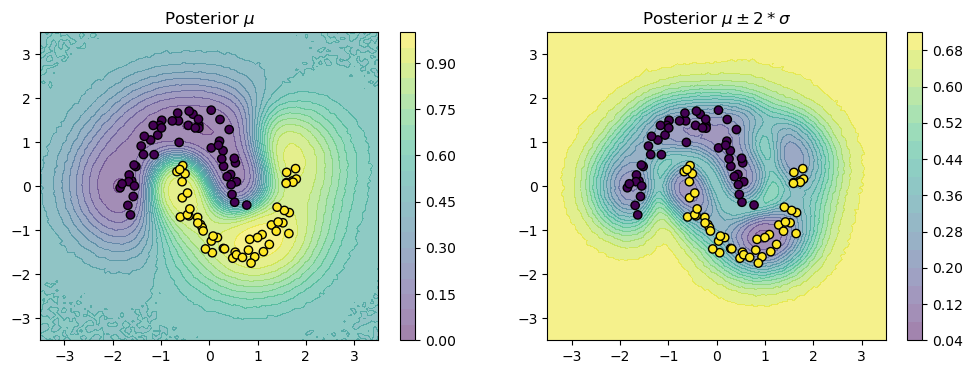

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
cplot1 = ax[0].contourf(X1, X2, proba_mean.squeeze(), alpha=0.5, levels=20)
plt.colorbar(cplot1, ax=ax[0])

cplot2 = ax[1].contourf(X1, X2, proba_std2.squeeze(), alpha=0.5, levels=20)
plt.colorbar(cplot2, ax=ax[1])

ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[1].scatter(X[:, 0], X[:, 1], c=y)

ax[0].set_title("Posterior $\mu$")
ax[1].set_title("Posterior $\mu \pm 2*\sigma$")
